# Monte Carlo sampling 
Als alternatief voor _grid search_ zouden we via _sampling_ kunnen werken.

1. We starten met een eerste berekende gok voor de parameters en berekenen de $SSE$ _loss_ bij de start
2. Daarna itereren we (30k keer) over volgende stappen:
    - We nemen een sample uit een normale verdeling met gemiddelde $0$ om een kleine aanpassing te doen aan de parameterschattingen (in positieve of negatieve zin).
    - We zorgen dat de bijgewerkte schattingen binnen een realistisch interval blijven.
    - We berekenen de $SSE$ _loss_ opnieuw. Als de nieuwe $SSE$ is gedaald, behouden we de nieuwe parameterwaarden. In het andere geval verwerpen we ze.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from ml_courses.sim.monte_carlo_tips import MonteCarloTipsSimulation

In [2]:
# Generate data
sim = MonteCarloTipsSimulation()

# Random number generator for reproducibility
rng = np.random.default_rng(67)

# Standardized variables
order_totals = (sim.order_totals - np.mean(sim.order_totals)) / np.std(sim.order_totals)
observed_tips = (sim.observed_tips - np.mean(sim.observed_tips)) / np.std(sim.observed_tips)

# Initial guesses
b1 = rng.uniform(-2.0, 2.0)
b2 = rng.uniform(-1.0, 3.0)

# Initial SSE loss
current_loss = sim.calculate_loss(b1, b2, order_totals, observed_tips)
print(
    f"Current SSE loss: {current_loss:.2f} (with guess: {b1:.2f} + {b2:.2f} × standardized_order)"
)

# Containers to keep track of all our attempts
b1_samples = []
b2_samples = []
loss_samples = []

n_accepted = 0  # Count how many proposals we accepted
n_samples = 30000  # Total number of samples to draw
step_size = 0.0001  # How big of a step to take when proposing new

for i in range(n_samples):
    # Propose slight changes to our current best guess
    b1_new = b1 + rng.normal(0, step_size * 5)  # Base tip can vary more
    b2_new = b2 + rng.normal(0, step_size)

    # Keep parameters reasonable (tip rate: 0-50%, base tip: $0-5)
    b1_new = np.clip(b1_new, 0, 50)
    b2_new = np.clip(b2_new, 0, 1.0)

    new_loss = sim.calculate_loss(b1_new, b2_new, order_totals, observed_tips)

    # Decide whether this new relationship is worth keeping
    accept = False
    if new_loss < current_loss:
        # This predicts tips better - definitely keep it!
        accept = True

    if accept:
        b1 = b1_new
        b2 = b2_new
        current_loss = new_loss
        n_accepted += 1

    # Record our current best guess (whether we moved or stayed)
    b1_samples.append(b1)
    b2_samples.append(b2)
    loss_samples.append(current_loss)

    # Show progress
    if i == 0 or (i + 1) % 1000 == 0:
        tip_pct = b2 * 100
        print(
            f"Sample {i + 1:5d}: Standardized Tip = {b1:.2f} + {b2:.2f} × Standardized Order Total, loss={current_loss:.1f}"
        )

acceptance_rate = n_accepted / n_samples
print(f"\n✅ Finished! Accepted {acceptance_rate:.1%} of proposed changes")

Current SSE loss: 115.68 (with guess: -0.34 + -0.49 × standardized_order)
Sample     1: Standardized Tip = 0.00 + 0.00 × Standardized Order Total, loss=50.0
Sample  1000: Standardized Tip = 0.00 + 0.04 × Standardized Order Total, loss=46.2
Sample  2000: Standardized Tip = 0.00 + 0.08 × Standardized Order Total, loss=42.8
Sample  3000: Standardized Tip = 0.00 + 0.12 × Standardized Order Total, loss=39.3
Sample  4000: Standardized Tip = 0.00 + 0.16 × Standardized Order Total, loss=35.8
Sample  5000: Standardized Tip = 0.01 + 0.20 × Standardized Order Total, loss=32.8
Sample  6000: Standardized Tip = 0.00 + 0.24 × Standardized Order Total, loss=29.8
Sample  7000: Standardized Tip = 0.01 + 0.28 × Standardized Order Total, loss=27.0
Sample  8000: Standardized Tip = 0.01 + 0.32 × Standardized Order Total, loss=24.4
Sample  9000: Standardized Tip = 0.01 + 0.35 × Standardized Order Total, loss=21.9
Sample 10000: Standardized Tip = 0.01 + 0.40 × Standardized Order Total, loss=19.5
Sample 11000:

## Visualisatie van het $SSE$ oppervlak

Nu we de Monte Carlo sampling hebben uitgevoerd, kunnen we stappen visualiseren op het $SSE$ oppervlak. Zo zien we hoe het algoritme "bergafwaarts" beweegt naar het minimum.

In [3]:
from ml_courses.sim.linear_regression_sse_viz import LinearRegressionSSEVisualizer

viz = LinearRegressionSSEVisualizer(
    x_data=sim.order_totals,
    y_data=sim.observed_tips,
    true_bias=sim.true_b1,
    true_slope=sim.true_b2,
    standardize=True,
)

fig = viz.create_3d_surface_plot(
    bias_samples=np.array(b1_samples),
    slope_samples=np.array(b2_samples),
    loss_samples=np.array(loss_samples),
    resolution=40,
    scale_factor=1.1,
)
fig.show()

Hieronder herhalen we het naïeve Monte Carlo algorithme 10 keer en visualiseren we de resulterende regressielijnen.

In [4]:
b1_sims = []
b2_sims = []

for _ in range(10):
    sim_run = sim.run_simulation(
        n_samples=15000,
        step_size=0.0001,
        b1_init=rng.uniform(-2.0, 2.0),
        b2_init=rng.uniform(-1.0, 3.0),
        b1_bounds=(-10, 10),
        b2_bounds=(-8, 10),
        order_totals=order_totals,
        observed_tips=observed_tips,
    )
    print(
        f"Estimated relationship: Standardized Tip = {sim_run['final_b1']:.2f} + {sim_run['final_b2']:.2f} × Standardized Order Total"
    )
    b1_sims.append(sim_run["final_b1"])
    b2_sims.append(sim_run["final_b2"])

Estimated relationship: Standardized Tip = 0.00 + 0.55 × Standardized Order Total
Estimated relationship: Standardized Tip = 0.00 + -0.13 × Standardized Order Total
Estimated relationship: Standardized Tip = 0.01 + 2.30 × Standardized Order Total
Estimated relationship: Standardized Tip = 0.00 + 0.53 × Standardized Order Total
Estimated relationship: Standardized Tip = 0.02 + 2.25 × Standardized Order Total
Estimated relationship: Standardized Tip = 0.00 + 2.15 × Standardized Order Total
Estimated relationship: Standardized Tip = -0.00 + 0.53 × Standardized Order Total
Estimated relationship: Standardized Tip = 0.00 + 0.93 × Standardized Order Total
Estimated relationship: Standardized Tip = -0.01 + 2.30 × Standardized Order Total
Estimated relationship: Standardized Tip = -0.00 + 0.95 × Standardized Order Total


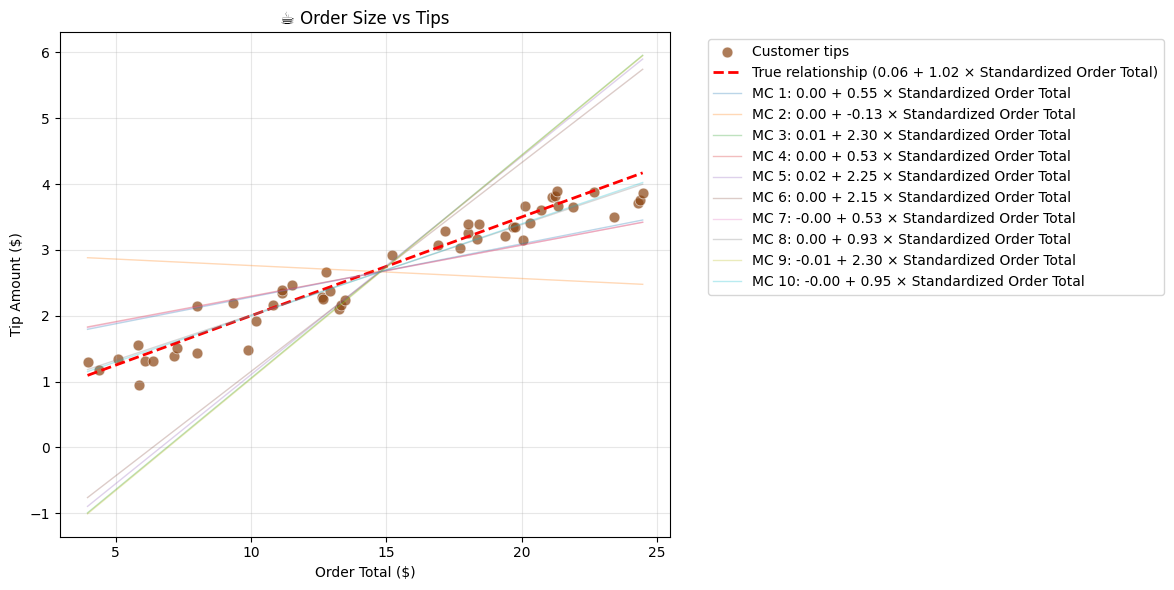

In [5]:
# Plot the simulations
plt.figure(figsize=(12, 6))
plt.scatter(
    sim.order_totals,
    sim.observed_tips,
    alpha=0.7,
    color="saddlebrown",
    s=60,
    edgecolor="white",
    linewidth=0.5,
    label="Customer tips",
)

true_b1 = (
    sim.true_b1 + sim.true_b2 * np.mean(sim.order_totals) - np.mean(sim.observed_tips)
) / np.std(sim.observed_tips)
true_b2 = sim.true_b2 * (np.std(sim.order_totals) / np.std(sim.observed_tips))
true_tips = sim.true_b1 + sim.true_b2 * sim.order_totals
plt.plot(
    sim.order_totals,
    true_tips,
    "r--",
    linewidth=2,
    label=f"True relationship ({true_b1:.2f} + {true_b2:.2f} × Standardized Order Total)",
)

colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
]

for i, (b1_sim, b2_sim) in enumerate(zip(b1_sims, b2_sims, strict=False)):
    sim_tips = b1_sim + b2_sim * order_totals
    sim_tips = sim_tips * np.std(sim.observed_tips) + np.mean(sim.observed_tips)
    plt.plot(
        sim.order_totals,
        sim_tips,
        color=colors[i],
        linestyle="-",
        alpha=0.3,
        linewidth=1,
        label=f"MC {i + 1}: {b1_sim:.2f} + {b2_sim:.2f} × Standardized Order Total",
    )

plt.xlabel("Order Total ($)")
plt.ylabel("Tip Amount ($)")
plt.title("☕ Order Size vs Tips")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

De simpele Monte Carlo benadering levert duidelijk onstabiele resultaten op. In de volgende secties bekijken we betere alternatieven op basis van _calculus_. Daarvoor behandelen we eerst het concept van de **_gradient_ van de _loss_ functie**.